# KLT Tracking





## Google Colab


In [1]:
# from google.colab import drive

# drive.mount('/content/drive')
# %cd '/content/drive/MyDrive/Colab Notebooks'

# import numpy as np
# import cv2
# import matplotlib.pyplot as plt
# import math
# import scipy.signal
# import scipy.linalg
# import importlib
# import mae6292.tools as mae6292

# from google.colab.patches import cv2_imshow
# from google.colab import files as FILE
# import os

## Jupyter Notebook

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
import scipy.signal
import scipy.linalg
import mae6292.tools as mae6292
import importlib

from mae6292.imshow import cv2_imshow

## Load Data

The following data are given:

1.  Database image `data/000000.png`
2.  Keypoints in the database image `data/keypoints.txt`
3.  3D location of the keypoints in the W-frame `data/p_W_landmarks.txt`



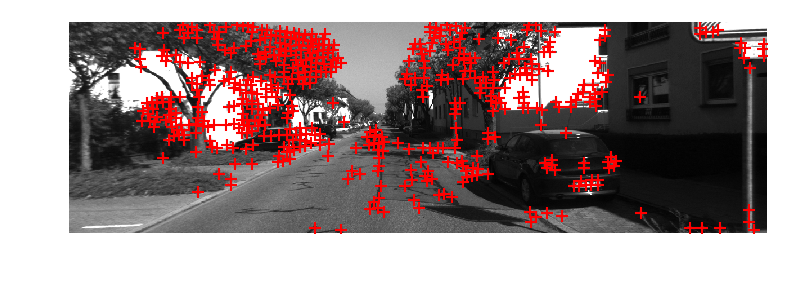

In [2]:
img_database = cv2.imread('data/000000.png',cv2.IMREAD_GRAYSCALE)
keypoints_database = list(map(tuple, np.loadtxt('data/keypoints.txt', dtype='int')-1)) # list of (row, col)
K = np.loadtxt('data/K.txt')
p_W_landmarks = np.loadtxt('data/p_W_landmarks.txt').T

plt.figure(dpi=150)
plt.imshow(img_database,cmap='gray')
plt.axis('off')
plt.plot(np.array(keypoints_database).T[1,:],np.array(keypoints_database).T[0,:],'r+')

## Notations

We have defined the keypoints in several ways. 

* **Keypoints**: python list of `(row,col)`
```
keypoints = [ (row_0, col_0), (row_1, col_1), ....]
```
* **p**: `2 by n np.array` of the pixel coordinate `(u,v)=(col,row)`. 
`keypoints` can be converted to `p` by
```
p = np.array(keypoints, dtype='float32').T # conver list to np.array
p = p[[1,0],:] # swap row and col
```
Note OpenCV requires the data type `float32` and the `n by 2` array. As such, `p` should be transposed before taking as an input to an OpenCV function, and after taking as an output of an OpenCV function.

* **p_ho**: `3 by n np.array` of the homogeneous pixel coordinate `(u,v,1)=(col,row)`, obtained by

```
p_ho = np.concatenate((p, np.ones((1,p.shape[1])) ), axis=0) 
```

## KLT Tracker

KLT tracker has been implemented by [cv2.caclOpticalFlowPyrLK()](https://docs.opencv.org/master/dc/d6b/group__video__track.html#ga473e4b886d0bcc6b65831eb88ed93323)

```
p_cur_T, bool_track, _ = cv2.calcOpticalFlowPyrLK(img_pre, img_cur, p_pre.T, None, winSize  = (15,15))
```
where `book_track` is `n by 1` np.array defined such that `bool_track[i]==1` implies that `p_pre[i]` is tracked.


N_tracked= 490


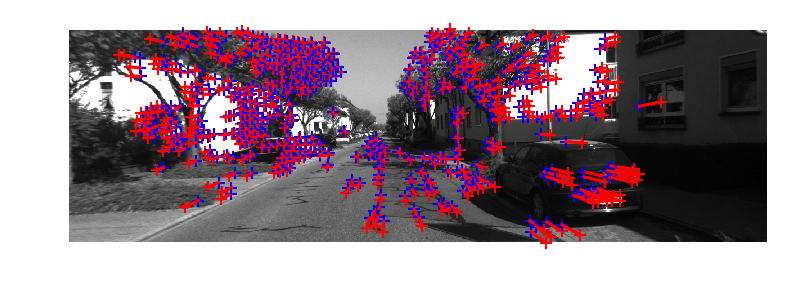

In [3]:
# load data are converted into img and keypoints of the previous frame

img_pre = img_database
p_pre = np.array(keypoints_database, dtype='float32').T
p_pre = p_pre[[1,0],:] 

# load the current image
img_cur = cv2.imread('data/000001.png',cv2.IMREAD_GRAYSCALE)

# KLT tracker
W_KLT = 5
p_cur_T, bool_track, _ = cv2.calcOpticalFlowPyrLK(img_pre, img_cur, p_pre.T, None, winSize  = (2*W_KLT+1,2*W_KLT+1))
p_cur = p_cur_T.T

index_track = np.where(bool_track.flatten()>0)[0]
print('N_tracked=',len(index_track))

# extract tracked keypoints
p_pre_tracked = p_pre[:,index_track]
p_cur_tracked = p_cur[:,index_track]

# visualization
plt.figure(dpi=150)
plt.imshow(img_cur,cmap='gray')
plt.axis('off')

for i in range(len(index_track)):
    u_q, v_q = p_cur_tracked[0,i], p_cur_tracked[1,i] # matched keypoints on img_cur
    u_d, v_d = p_pre_tracked[0,i], p_pre_tracked[1,i] # matched keypoints on img_pre
    plt.plot(u_q, v_q, 'r+') 
    plt.plot(u_d, v_d, 'b+')
    plt.plot([u_d,u_q],[v_d,v_q],'r')

## Outlier Rejection 

Compared with the RANSAC Harris feature matching in Homework 8, where we obtained about 230 matched features, KLT tracker was able to track 490 features. Another benefit is that the tracked keypoint location is expressed by floating numbers, which is more useful to improve accuracy of triangulation. 

But, it is still possible that the tracked features include outlilers. Of course, we can apply RANSAC to KLT to eliminate outliers. We will present another simple test to verify that the feature is tracked consistently. Let
$\Psi_i^{i+1}(p)$ be the point $p$ at the image $I_i$ tracked to the image $I_{i+1}$ by KLT. The bi-directional error is defied by

\begin{align*}
\textrm{err_bidir} = \| \Psi_{i+1}^i (\Psi_i^{i+1} (p)) -p \|
\end{align*}

Ideally, the tracking from $I_{i+1}$ to $I_i$ is the inversion of the tracking from $I_i$ to $I_{i+1}$, and the above bi-directional error should be zero. The features whose bidirectional error is less than a threshold can be identified as inliers. 


N_tracked= 475


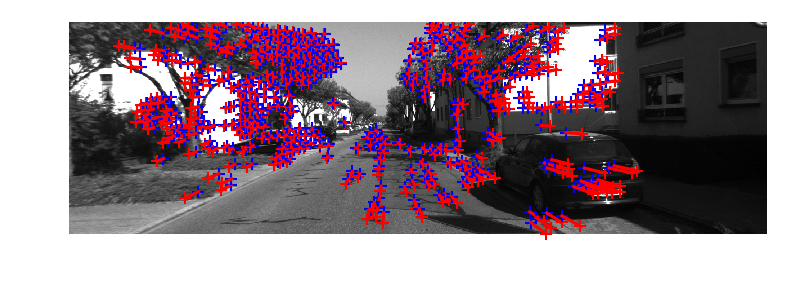

In [4]:
# load data are converted into img and keypoints of the previous frame

img_pre = img_database
p_pre = np.array(keypoints_database, dtype='float32').T
p_pre = p_pre[[1,0],:] 

# print(p_pre.shape)

# load the current image
img_cur = cv2.imread('data/000001.png',cv2.IMREAD_GRAYSCALE)

# KLT tracker: forward
p_cur_T, bool_track, _ = cv2.calcOpticalFlowPyrLK(img_pre, img_cur, p_pre.T, None, winSize  = (11,11))
p_cur = p_cur_T.T
# KLT tracker: backward
p_pre_rec_T, bool_track_backward, _ = cv2.calcOpticalFlowPyrLK(img_cur, img_pre, p_cur.T, None, winSize  = (11,11))
p_pre_recovered = p_pre_rec_T.T

# compute bi-directional error
err_bidir = np.sum((p_pre - p_pre_recovered)**2, axis=0)
tol_bidir = 1

# select inliers 
index_track = np.where( (bool_track.flatten()>0) & (bool_track_backward.flatten()>0) & (err_bidir < tol_bidir) )[0]

print('N_tracked=',len(index_track))

p_pre_tracked = p_pre[:,index_track]
p_cur_tracked = p_cur[:,index_track]

# visualization
plt.figure(dpi=150)
plt.imshow(img_cur,cmap='gray')
plt.axis('off')

for i in range(len(index_track)):
    u_q, v_q = p_cur_tracked[0,i], p_cur_tracked[1,i] # matched keypoints on img_cur
    u_d, v_d = p_pre_tracked[0,i], p_pre_tracked[1,i] # matched keypoints on img_pre
    plt.plot(u_q, v_q, 'r+') 
    plt.plot(u_d, v_d, 'b+')
    plt.plot([u_d,u_q],[v_d,v_q],'r')
    

The above KLT with bidirectional error has been implemented by
```
p_cur, index_track = mae6292.KLT(frame_pre, frame_cur, p_pre, W = 7, tol_bidir = 10, display = False)

```
where the keypoints do not have to be transposed.
